Derived from reading through ["What is `torch.nn` _really_?"](https://pytorch.org/tutorials/beginner/nn_tutorial.html).
* I find this generally ironic, because Jeremy likes to teach from a high-level
* This tutorial is going to be everything from the bottom-up

---

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

In [4]:
URL = "http://deeplearning.net/data/mnist/"

In [5]:
def make_filestructure(filename):
    if not (PATH / filename).exists():
        content = requests.get(URL + filename).content
        (PATH / filename).open("wb").write(content)

In [6]:
def load_train_validation_sets(filename):
    import pickle
    import gzip
    
    with gzip.open((PATH / filename).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        return ((x_train, y_train), (x_valid, y_valid))

Now let's actually bring in the data

In [7]:
FILENAME = "mnist.pkl.gz"

make_filestructure(FILENAME)

Just a sidenote - this is __totally__ how Jeremy Howard codes:
1. Very brief, but super-effective, blocks of code
2. No comments, but the code is so _direct_ that the given assumption that you can code in Python is all you need

In [8]:
xy_train, xy_valid = load_train_validation_sets(FILENAME)

In [11]:
def show_one_digit(images_flat):
    from matplotlib import pyplot
    import numpy as np
    
    random_index = np.random.randint(len(images_flat), size=1)[0]
    # show our random image in grayscale
    pyplot.imshow(images_flat[random_index].reshape((28, 28)), cmap="gray")
    print("images.shape =", images_flat.shape)

images.shape = (50000, 784)


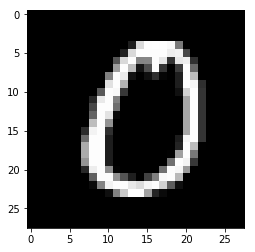

In [15]:
# pass in the training set, but it doesn't really matter which one we look at
show_one_digit(xy_train[0])

# Torch-ify me cap'n!

In [17]:
import torch

def convert_np_to_torch(images_as_numpy):
    '''
    Args:
        images_as_numpy: all data as np.array's, concatenated together.
            I.e. (x_train, y_train, x_val, y_val[, x_test, y_test])
    '''
    return map(torch.tensor, (*images_as_numpy,))

x_train, y_train, x_valid, y_valid = convert_np_to_torch((*xy_train, *xy_valid))

In [18]:
x_train, y_train

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4,  ..., 8, 4, 8]))

In [22]:
n, c = x_train.shape # number of samples, columns (?)
print(n, c, 'from', x_train.shape)

50000 784 from torch.Size([50000, 784])


In [23]:
print(y_train.min(), y_train.max())

tensor(0) tensor(9)


In [24]:
def mnist_weights_and_biases():
    '''Return (weights, bias) constructed from a Normal Distribution, and "Xavier-initialized"'''
    import math
    
    weights = torch.randn(784, 10) / math.sqrt(784)
    weights.requires_grad_() # set requires_grad = True post-hoc
    
    bias = torch.zeros(10, requires_grad=True)
    
    return weights, bias

Because PyTorch can construct optimized GPU code (with a cuDNN optimizing compiler?) we're going to write two
  functions for use
1. A "softmax" function, which predicts a probability distribution
2. A "model" function, because anything that is invocable can be a PyTorch model
  * And the gradients will still be calculated!

In [29]:
def simple_linear_model():
    '''To encapsulate the shenanigans that are about to ensue, I will work in a function'''
    
    def log_softmax(x):
        return x - x.exp().sum(-1).log().unsqueeze(-1)

    def model(mini_batch, weights, bias):
        return log_softmax(mini_batch @ weights + bias)
    
    w, b = mnist_weights_and_biases()
    
    bs = 64 # batch size
    
    x_b = x_train[0:bs] # a mini-batch from our inputs
    predictions = model(x_b, w, b)
    
    print('Prediction 1:', predictions[0])
    print('predictions.shape', predictions.shape)

In [30]:
simple_linear_model()

Prediction 1: tensor([-2.2249, -2.5399, -2.2281, -2.3276, -2.1397, -2.2130, -2.7316, -2.3885,
        -2.0396, -2.3669], grad_fn=<SelectBackward>)
predictions.shape torch.Size([64, 10])


Again, for the sake of keeping the global namespace relatively unpolluted (until we get to the `torch.nn` stuff)
  I'm going to simple rewrite `simple_linear_model`.
* With the caviate of pulling up `log_softmax(x)` for its general utility

In [44]:
def _feeling_out_torch_sum():
    # give me [0, 120) and arrange the as 4 blocks of 5x6 matrices
    b = torch.arange(4 * 5 * 6).view(4, 5, 6)
    
    a = torch.arange(10 * 2).view(2, 10)
    print(a)
    print(a.sum(0))

In [45]:
_feeling_out_torch_sum()

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])
tensor([10, 12, 14, 16, 18, 20, 22, 24, 26, 28])


In [63]:
# ?torch.exp

In [64]:
def _feeling_out_torch_unsqueeze():
#     ?torch.unsqueeze
    small_range = torch.arange(1., 3., .5)
    print(small_range)
    
    _sum = small_range.sum()
    print(_sum)
    
    print(_sum.unsqueeze(-1))
    print(_sum.log())
    print(_sum.log().unsqueeze(-1))

In [65]:
_feeling_out_torch_unsqueeze()

tensor([1.0000, 1.5000, 2.0000, 2.5000])
tensor(7.)
tensor([7.])
tensor(1.9459)
tensor([1.9459])


(Log) Softmax, here, is the difference of
1. the input, and
2. the log of the sum along the last dimension of the exponential of the input

Then it just boxes that log.
* Why index `-1` rather than `0` for a scalar value? I don't know, but maybe we can find out

In [62]:
torch.Tensor(1).unsqueeze(-1), torch.Tensor(1).unsqueeze(0)

(tensor([[0.]]), tensor([[0.]]))

No difference when there's one element, but how about with multiple?

In [66]:
torch.Tensor(3).unsqueeze(-1), torch.Tensor(3).unsqueeze(0)

(tensor([[ 0.0000e+00],
         [-3.6893e+19],
         [ 1.0140e+16]]), tensor([[ 0.0000e+00, -3.6893e+19,  1.0149e+16]]))

There it is. `unsqueeze(-1)` is guaranteed to box the elements.
* If, for some reason, the last dimension in your sum was a vector, this `unsqueeze` would make sure that
  you have individually boxes elements (in this case, probabilities)

---
Another token Jeremy Howard-ism:
* Great coding practices, but he doesn't explain them along the way.
* He wants you to trust his implementation, and know enough to dig in yourself (as I have done above)

---

In [68]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

In [70]:
def neg_log_likelihood(x, target):
    return -x[range(target.shape[0]), target].mean()

In [96]:
def accuracy(out, target_batch):
    preds = torch.argmax(out, dim=1) # this is weird to me
    return (preds == target_batch).float().mean() # average accuracy of the predictions

In [98]:
# ?torch.argmax

It gets the indices of the maximum values of the rows of the linear regression...
* Why is that how we determine out prediction?

In [114]:
def simple_linear_model():
    '''To encapsulate the shenanigans that are about to ensue, I will work in a function'''

    w, b = mnist_weights_and_biases()
    
    def model(mini_batch):
        return log_softmax(mini_batch @ w + b)
    
    
    bs = 64 # batch size
    
    x_b = x_train[0:bs] # a mini-batch from our inputs
    predictions = model(x_b)
    
    print('Prediction 1:', predictions[0])
    print('predictions.shape', predictions.shape)
    
    loss_func = neg_log_likelihood
    
    y_b = y_train[0:bs]
    
    print(loss_func(predictions, y_b))
    
    lr = 0.5
    epochs = 2 # how many laps through the dataset

    print(f"training our model {epochs} epochs with learning rate of {lr}")
    for epoch in range(epochs):
        # this 'i' is sometimes called a "period" when iterating through the dataset
        for i in range((n - 1) // bs + 1): # why n-1?
            start_i = i * bs
            end_i = start_i + bs # now we have a range [i*bs, (i+1)*bs)
            
            x_mini_batch = x_train[start_i: end_i]
            y_mini_batch = y_train[start_i: end_i]
            
            prediction = model(x_mini_batch) # prediction matrix of matrices ("tensor")
            loss = loss_func(prediction, y_mini_batch)
            
            if i % 100 == 0: # do some logging every 20th batch
                print(f' Loss of {loss}, with batch accuracy of {accuracy(prediction, y_mini_batch)}')
            
            loss.backward()
            with torch.no_grad():
                w -= w.grad * lr
                b -= b.grad * lr
                w.grad.zero_()
                b.grad.zero_()
    
    print(loss_func(model(x_b), y_b), accuracy(model(x_b), y_b))

In [117]:
simple_linear_model()

Prediction 1: tensor([-2.6693, -1.9444, -2.4209, -2.5773, -1.7092, -1.8297, -3.0054, -2.6381,
        -2.5624, -2.4865], grad_fn=<SelectBackward>)
predictions.shape torch.Size([64, 10])
tensor(2.3040, grad_fn=<NegBackward>)
training our model 2 epochs with learning rate of 0.5
 Loss of 2.3039698600769043, with batch accuracy of 0.09375
 Loss of 0.3145824670791626, with batch accuracy of 0.90625
 Loss of 0.30414271354675293, with batch accuracy of 0.875
 Loss of 0.39955586194992065, with batch accuracy of 0.921875
 Loss of 0.23822332918643951, with batch accuracy of 0.890625
 Loss of 0.3744773268699646, with batch accuracy of 0.890625
 Loss of 0.26767498254776, with batch accuracy of 0.890625
 Loss of 0.3798275589942932, with batch accuracy of 0.90625
 Loss of 0.2802697420120239, with batch accuracy of 0.921875
 Loss of 0.263016015291214, with batch accuracy of 0.921875
 Loss of 0.19756793975830078, with batch accuracy of 0.90625
 Loss of 0.34718382358551025, with batch accuracy of 0.92